In [18]:
 import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import math
import yaml
from torch.utils.data.dataloader import DataLoader
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import wasserstein_distance
from itertools import combinations
from numpy import corrcoef
import random
from scipy.stats import spearmanr
import scanpy as sc
import pertpy as pt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
adata = ad.read_h5ad("../../data/sciplex/sciplex3_uce_adata.h5ad")

In [3]:
adata.X = adata.X.toarray()

In [4]:
def preprocess_adata(adata_copy, cell_type):
    """
    Preprocess adata object using the Ji. et. Al. steps:
    Subsample adata to include only a single cell type, log-normalization, 2000 HVG gene selectio 
    using scanpy with default parameters
    """

    #subsample
    adata = adata_copy[adata_copy.obs['cell_type'] == cell_type].copy()
    
    sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var['highly_variable']]
    # sc.pp.pca(adata, use_highly_variable=True)
    # adata.obs_names_make_unique()
    # adata.var_names_make_unique()

    adata.layers["X_hvg"] = adata.X

    return adata

In [5]:
def get_disjoint_control_sets(adata):
    adata_control = adata[adata.obs['product_name'] == "Vehicle"]

    num_sets = 5
    cells_per_set  = 300
    n_total = adata_control.n_obs
    
    all_indices = np.arange(n_total)
    random.seed(1702)
    random.shuffle(all_indices)
    
    # Split indices into disjoint sets
    disjoint_sets = []
    for i in range(num_sets):
        start_idx = i * cells_per_set
        end_idx = start_idx + cells_per_set
        disjoint_set_indices = all_indices[start_idx:end_idx]
        disjoint_sets.append(disjoint_set_indices)
    
    # create new AnnData objects for each set
    disjoint_adata_sets = [adata_control[indices].copy() for indices in disjoint_sets]

    # Output the sets
    for i, indices in enumerate(disjoint_sets):
        print(f"Set {i + 1}: {len(indices)} cells")

    return disjoint_adata_sets

In [6]:
def get_results_for_dist_metric(adata, metric, disjoint_sets, cell_type_name):
    """
    Get metrics for a given distance function, for both
    embedding space and gene-expression space
    """

    #within distance between control sets

    within_control_distance_gs = []
    within_control_distance_es = []
    
    for i in range(len(disjoint_sets)):

        dist_gs = 0
        dist_es = 0
        
        for j in range(len(disjoint_sets)):
            if i != j:
                ad1 = disjoint_sets[i]
                ad2 = disjoint_sets[j]

                ad1.obs['PERT_CONDITION'] = str(i)
                ad2.obs['PERT_CONDITION'] = str(j)

                adata_comparison = ad.concat([ad1, ad2])

                dist_object_gs = pt.tools.Distance(metric=metric, layer_key="X_hvg")
                dist_object_es = pt.tools.Distance(metric=metric, obsm_key="X_uce")

                dist_df_gs = dist_object_gs.onesided_distances(adata_comparison, groupby="PERT_CONDITION", selected_group=str(i), groups=[str(j)], show_progressbar=False)
                dist_df_es = dist_object_es.onesided_distances(adata_comparison, groupby="PERT_CONDITION", selected_group=str(i), groups=[str(j)], show_progressbar=False)
  
                dist_gs += dist_df_gs.iloc[0]
                dist_es += dist_df_es.iloc[0]

        within_control_distance_gs.append(dist_gs / (len(disjoint_sets) - 1))
        within_control_distance_es.append(dist_es / (len(disjoint_sets) - 1))

                
    #distance between control sets and perturbations
    between_distance_gs = []
    between_distance_es = []

    
    print("Calculating CRP, Robusntess ...")
    
    for product_dose in tqdm(list(adata.obs['product_dose'].unique())):
        if product_dose == "Vehicle_0":
            continue

        pert_adata = adata[adata.obs['product_dose'] == product_dose]

        dist_perturbation_gs = 0
        dist_perturbation_es = 0

        for ctrl_adata in disjoint_sets:

            #create adata with control cells and perturbation condition
            adata_comparison = ad.concat([ctrl_adata, pert_adata])

            #compute distance using pertpy
            dist_object_gs = pt.tools.Distance(metric=metric, layer_key="X_hvg")
            dist_object_es = pt.tools.Distance(metric=metric, obsm_key="X_uce")
            
            dist_df_gs = dist_object_gs.onesided_distances(adata_comparison, groupby="product_dose", selected_group="Vehicle_0", groups=[product_dose], show_progressbar=False)
            dist_df_es = dist_object_es.onesided_distances(adata_comparison, groupby="product_dose", selected_group="Vehicle_0", groups=[product_dose], show_progressbar=False)

            dist_perturbation_gs += dist_df_gs.iloc[0]
            dist_perturbation_es += dist_df_es.iloc[0]

        num_ctrl_sets = len(disjoint_sets)
        
        between_distance_gs.append(dist_perturbation_gs / num_ctrl_sets)
        between_distance_es.append(dist_perturbation_es / num_ctrl_sets)


    #calculate CRP, robustness metrics - gene space
    CRP_list_gs = []
    
    for ctrl_ctrl_dist in within_control_distance_gs:
        num_smaller = 0
        for ctrl_pert_dist in between_distance_gs:
            if ctrl_ctrl_dist > ctrl_pert_dist:
                num_smaller += 1

        crp_fold_gs = num_smaller / len(between_distance_gs)
        CRP_list_gs.append(crp_fold_gs)

    CRP_gs = 1 - float(np.mean(CRP_list_gs))
    ROBUSTNESS_gs = 1 / (1 + np.var(CRP_list_gs))

    #calculate CRP, robustness metrics - embedding space
    CRP_list_es = []

    for ctrl_ctrl_dist in within_control_distance_es:
        num_smaller = 0
        for ctrl_pert_dist in between_distance_es:
            if ctrl_ctrl_dist > ctrl_pert_dist:
                num_smaller += 1

        crp_fold_es = num_smaller / len(between_distance_es)
        CRP_list_es.append(crp_fold_es)

    CRP_es = 1 - float(np.mean(CRP_list_es))
    ROBUSTNESS_es = 1 / (1 + np.var(CRP_list_es))

    #calculate BioReplicability
    correlations_gs = list()
    correlations_es = list()

    print("Calculating BioRep ...")
    for drug in tqdm(list(adata.obs['product_name'].unique())):
        if drug == "Vehicle":
            continue
            
        ad_perturb = adata[adata.obs['product_name'] == drug]

        doses = list()
        distances_gs = list()
        distances_es = list()

        for dose in sorted(list(ad_perturb.obs['dose'].unique())):
            doses.append(dose)

            dist_per_set_gs = list()
            dist_per_set_es = list()
            
            for dj in disjoint_sets:
                
                ad_perturb_dose = ad_perturb[ad_perturb.obs['dose'] == dose]
                prod_dose_key = list(ad_perturb_dose.obs['product_dose'].unique())
                assert len(prod_dose_key) == 1
                prod_dose_key = prod_dose_key[0]
    
                adata_comparison = ad.concat([dj, ad_perturb_dose])
    
                dist_object_gs = pt.tools.Distance(metric=metric, layer_key="X_hvg")
                dist_object_es = pt.tools.Distance(metric=metric, obsm_key="X_uce")
    
                dist_df_gs = dist_object_gs.onesided_distances(adata_comparison, groupby="product_dose", selected_group="Vehicle_0", groups=[prod_dose_key], show_progressbar=False)
                dist_df_es = dist_object_es.onesided_distances(adata_comparison, groupby="product_dose", selected_group="Vehicle_0", groups=[prod_dose_key], show_progressbar=False)

                dist_per_set_gs.append(dist_df_gs.iloc[0])
                dist_per_set_es.append(dist_df_es.iloc[0])
            
            
            distances_gs.append(np.mean(dist_per_set_gs))
            distances_es.append(np.mean(dist_per_set_es))

        corr_gs, _ = spearmanr(doses, distances_gs)
        corr_es, _ = spearmanr(doses, distances_es)

        correlations_gs.append(corr_gs)
        correlations_es.append(corr_es)

    BIOREP_gs = np.mean(correlations_gs)
    BIOREP_es = np.mean(correlations_es)

    return {"GS": (CRP_gs, ROBUSTNESS_gs, BIOREP_gs), "ES": (CRP_es, ROBUSTNESS_es, BIOREP_es), "metric": metric, "cell_type": cell_type_name}

In [16]:
cell_type_names = ["A549", "K562", "MCF7"]
metrics = ["edistance", "euclidean", "root_mean_squared_error", "mse", "mean_absolute_error", 
           "pearson_distance", "kendalltau_distance", "cosine_distance",
          "r2_distance", "mmd", "sym_kldiv"]

results = list()

for cell_type_name in cell_type_names:
    adata_subset = preprocess_adata(adata, cell_type_name)
    disjoint_sets = get_disjoint_control_sets(adata_subset)
    
    for metric in metrics:
        res = get_results_for_dist_metric(adata_subset, metric, disjoint_sets, cell_type_name)
        print(res)
        results.append(res)

with open("./all_dist_comparisons.pkl", "wb") as f:
    pkl.dump(results, f)


/tmp/ipykernel_3329439/3214242831.py:19: ImplicitModificationWarning: Setting element `.layers['X_hvg']` of view, initializing view as actual.
  adata.layers["X_hvg"] = adata.X


Set 1: 300 cells
Set 2: 300 cells
Set 3: 300 cells
Set 4: 300 cells
Set 5: 300 cells
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [07:12<00:00,  1.74it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [07:21<00:00,  2.33s/it]


{'GS': (1.0, 1.0, 0.5765957446808511), 'ES': (0.9928191489361702, 0.9999274328354113, 0.6074468085106383), 'metric': 'edistance', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.69it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:41<00:00,  4.60it/s]


{'GS': (0.9997340425531915, 0.999999717066626, 0.5744680851063829), 'ES': (0.9632978723404255, 0.9984070796960146, 0.6138297872340426), 'metric': 'euclidean', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:35<00:00, 20.94it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:41<00:00,  4.61it/s]


{'GS': (0.9997340425531915, 0.999999717066626, 0.5744680851063829), 'ES': (0.9632978723404255, 0.9984070796960146, 0.6138297872340426), 'metric': 'root_mean_squared_error', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.56it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:42<00:00,  4.47it/s]


{'GS': (0.9997340425531915, 0.999999717066626, 0.576595744680851), 'ES': (0.964095744680851, 0.9985471286190235, 0.6117021276595744), 'metric': 'mse', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.52it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:41<00:00,  4.55it/s]


{'GS': (0.9997340425531915, 0.999999717066626, 0.5499999999999999), 'ES': (0.9718085106382979, 0.9992187242687538, 0.6191489361702128), 'metric': 'mean_absolute_error', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:38<00:00, 19.68it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:42<00:00,  4.41it/s]


{'GS': (0.9946808510638298, 0.9999738293404216, 0.6170212765957447), 'ES': (0.9638297872340426, 0.9980935577161212, 0.6234042553191489), 'metric': 'pearson_distance', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:38<00:00, 19.49it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:43<00:00,  4.31it/s]


{'GS': (0.9835106382978723, 0.9997775223457093, 0.47127659574468084), 'ES': (0.9720744680851063, 0.999285396717914, 0.6234042553191489), 'metric': 'kendalltau_distance', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.62it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:41<00:00,  4.52it/s]


{'GS': (0.9936170212765958, 0.9999707172450104, 0.6212765957446809), 'ES': (0.9638297872340426, 0.9980935577161212, 0.6234042553191489), 'metric': 'cosine_distance', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:38<00:00, 19.56it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:43<00:00,  4.30it/s]


{'GS': (0.9941489361702127, 0.9999903803551007, 0.6276595744680851), 'ES': (0.961436170212766, 0.9983299496866449, 0.6159574468085107), 'metric': 'r2_distance', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:56<00:00, 13.27it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [01:02<00:00,  3.01it/s]


{'GS': (0.9997340425531915, 0.999999717066626, 0.576595744680851), 'ES': (0.964095744680851, 0.9985471286190235, 0.6117021276595744), 'metric': 'mmd', 'cell_type': 'A549'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [04:51<00:00,  2.58it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:54<00:00,  1.56s/it]


{'GS': (0.9912234042553192, 0.9999182389172002, 0.3489361702127659), 'ES': (0.9901595744680851, 0.999963502916513, 0.577659574468085), 'metric': 'sym_kldiv', 'cell_type': 'A549'}


/tmp/ipykernel_3329439/3214242831.py:19: ImplicitModificationWarning: Setting element `.layers['X_hvg']` of view, initializing view as actual.
  adata.layers["X_hvg"] = adata.X


Set 1: 300 cells
Set 2: 300 cells
Set 3: 300 cells
Set 4: 300 cells
Set 5: 300 cells
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [07:20<00:00,  1.71it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [07:25<00:00,  2.36s/it]


{'GS': (1.0, 1.0, 0.41063829787234035), 'ES': (0.9952127659574468, 0.9999571374189907, 0.4691489361702127), 'metric': 'edistance', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.46it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:41<00:00,  4.50it/s]


{'GS': (0.9992021276595745, 0.9999974536053977, 0.4021276595744681), 'ES': (0.9672872340425532, 0.998107509767794, 0.45319148936170206), 'metric': 'euclidean', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:37<00:00, 20.22it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:42<00:00,  4.49it/s]


{'GS': (0.9992021276595745, 0.9999974536053977, 0.4021276595744681), 'ES': (0.9672872340425532, 0.998107509767794, 0.45319148936170206), 'metric': 'root_mean_squared_error', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:37<00:00, 20.23it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:42<00:00,  4.49it/s]


{'GS': (0.9992021276595745, 0.9999974536053977, 0.4031914893617022), 'ES': (0.9672872340425532, 0.9982787712675124, 0.4553191489361702), 'metric': 'mse', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.46it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:41<00:00,  4.54it/s]


{'GS': (1.0, 1.0, 0.4308510638297872), 'ES': (0.9654255319148937, 0.9979613849029542, 0.4574468085106383), 'metric': 'mean_absolute_error', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:37<00:00, 19.83it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:43<00:00,  4.30it/s]


{'GS': (0.997872340425532, 0.9999925023196833, 0.42872340425531913), 'ES': (0.9694148936170213, 0.9984568609656449, 0.4617021276595745), 'metric': 'pearson_distance', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:39<00:00, 19.08it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:43<00:00,  4.36it/s]


{'GS': (1.0, 1.0, 0.42021276595744683), 'ES': (0.9739361702127659, 0.9988571247700968, 0.45957446808510644), 'metric': 'kendalltau_distance', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:36<00:00, 20.49it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:42<00:00,  4.47it/s]


{'GS': (0.9981382978723404, 0.9999946242932712, 0.42021276595744683), 'ES': (0.9696808510638298, 0.9984445914665532, 0.46489361702127663), 'metric': 'cosine_distance', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:42<00:00, 17.90it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:45<00:00,  4.18it/s]


{'GS': (0.9989361702127659, 0.9999983024021576, 0.39255319148936174), 'ES': (0.9675531914893617, 0.9981681141149258, 0.4436170212765958), 'metric': 'r2_distance', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [01:06<00:00, 11.25it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [01:06<00:00,  2.84it/s]


{'GS': (0.9992021276595745, 0.9999974536053977, 0.4031914893617022), 'ES': (0.9672872340425532, 0.9982787712675124, 0.4553191489361702), 'metric': 'mmd', 'cell_type': 'K562'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [04:49<00:00,  2.60it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:56<00:00,  1.57s/it]


{'GS': (0.9968085106382979, 0.9999868437674754, 0.35531914893617017), 'ES': (0.9941489361702127, 0.9999670393390439, 0.4670212765957447), 'metric': 'sym_kldiv', 'cell_type': 'K562'}


/tmp/ipykernel_3329439/3214242831.py:19: ImplicitModificationWarning: Setting element `.layers['X_hvg']` of view, initializing view as actual.
  adata.layers["X_hvg"] = adata.X


Set 1: 300 cells
Set 2: 300 cells
Set 3: 300 cells
Set 4: 300 cells
Set 5: 300 cells
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [10:26<00:00,  1.20it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [10:03<00:00,  3.20s/it]


{'GS': (0.6223404255319148, 0.9965495486922472, 0.5414893617021276), 'ES': (0.6848404255319149, 0.9877288440632589, 0.5957446808510638), 'metric': 'edistance', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:52<00:00, 14.25it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:57<00:00,  3.28it/s]


{'GS': (0.7593085106382979, 0.9914812116077697, 0.5606382978723404), 'ES': (0.7497340425531915, 0.9807524827863983, 0.5893617021276596), 'metric': 'euclidean', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:52<00:00, 14.41it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:57<00:00,  3.28it/s]


{'GS': (0.7593085106382979, 0.9914812116077697, 0.5606382978723404), 'ES': (0.7497340425531915, 0.9807524827863983, 0.5893617021276596), 'metric': 'root_mean_squared_error', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:52<00:00, 14.35it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:57<00:00,  3.27it/s]


{'GS': (0.7593085106382979, 0.9912768256367791, 0.5553191489361702), 'ES': (0.7476063829787234, 0.9798144745244494, 0.5893617021276595), 'metric': 'mse', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:52<00:00, 14.27it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:57<00:00,  3.27it/s]


{'GS': (0.6872340425531915, 0.9928066182988047, 0.5542553191489361), 'ES': (0.7446808510638298, 0.9826717360932515, 0.5925531914893617), 'metric': 'mean_absolute_error', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:54<00:00, 13.87it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:58<00:00,  3.21it/s]


{'GS': (0.723936170212766, 0.9981963046910622, 0.6223404255319149), 'ES': (0.7372340425531915, 0.9804850354941741, 0.5936170212765958), 'metric': 'pearson_distance', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:55<00:00, 13.66it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [01:00<00:00,  3.14it/s]


{'GS': (0.4319148936170213, 0.9976892586376167, 0.5457446808510639), 'ES': (0.7361702127659575, 0.9830362006474122, 0.5989361702127659), 'metric': 'kendalltau_distance', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:53<00:00, 14.20it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:58<00:00,  3.21it/s]


{'GS': (0.7231382978723404, 0.9983141585402763, 0.6191489361702128), 'ES': (0.7372340425531915, 0.9805578004477208, 0.5925531914893617), 'metric': 'cosine_distance', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [00:55<00:00, 13.63it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [01:00<00:00,  3.15it/s]


{'GS': (0.7406914893617021, 0.989219594351115, 0.5893617021276595), 'ES': (0.7430851063829786, 0.9806796889371928, 0.5946808510638297), 'metric': 'r2_distance', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [01:20<00:00,  9.40it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [01:26<00:00,  2.18it/s]


{'GS': (0.7590425531914894, 0.9912480515233596, 0.5553191489361702), 'ES': (0.7476063829787234, 0.9798144745244494, 0.5872340425531914), 'metric': 'mmd', 'cell_type': 'MCF7'}
Calculating CRP, Robusntess ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 753/753 [05:07<00:00,  2.45it/s]


Calculating BioRep ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [05:10<00:00,  1.64s/it]

{'GS': (0.276595744680851, 0.9997609783763218, 0.4117021276595745), 'ES': (0.6914893617021276, 0.9903282998276087, 0.5702127659574467), 'metric': 'sym_kldiv', 'cell_type': 'MCF7'}


In [27]:
with open("./all_dist_comparisons.pkl", "rb") as f:
    results = pkl.load(f)

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample DataFrame (replace with your actual data setup)
rows = []
for entry in results:
    metric = entry["metric"]
    cell_type = entry["cell_type"]
    for key in ["GS", "ES"]:
        scores = entry[key]
        rows.append({
            "Metric": metric,
            "Cell Type": cell_type,
            "Distance Space": key,
            "CRP": scores[0],
            "Robustness": scores[1],
            "BioRep": scores[2],
        })

df = pd.DataFrame(rows)

# Set color palette and style
sns.set(style="whitegrid")
distance_palette = sns.color_palette("tab10")
cell_type_palette = sns.color_palette("tab10")

/tmp/ipykernel_3329439/172390629.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


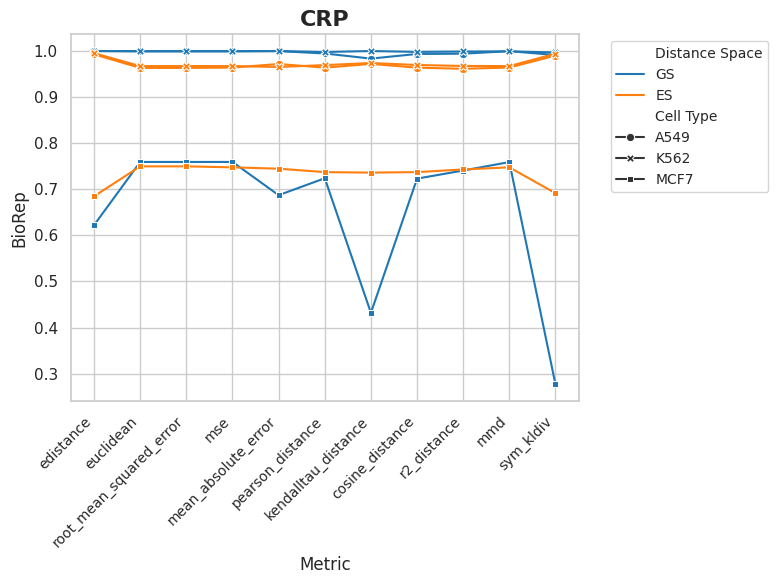

In [52]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df,
    x="Metric",
    y="CRP",
    hue="Distance Space",
    style="Cell Type",
    markers=True,
    dashes=False,
    palette=distance_palette,
)
plt.title(f"CRP", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Metric", fontsize=12)
plt.ylabel(score, fontsize=12)
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Place legend outside on the right
    ncol=1,
    fontsize=10,
    title_fontsize=12,
)
plt.tight_layout()

plt.savefig("./output/CRP_comparison_plot.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

/tmp/ipykernel_3329439/1385997106.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


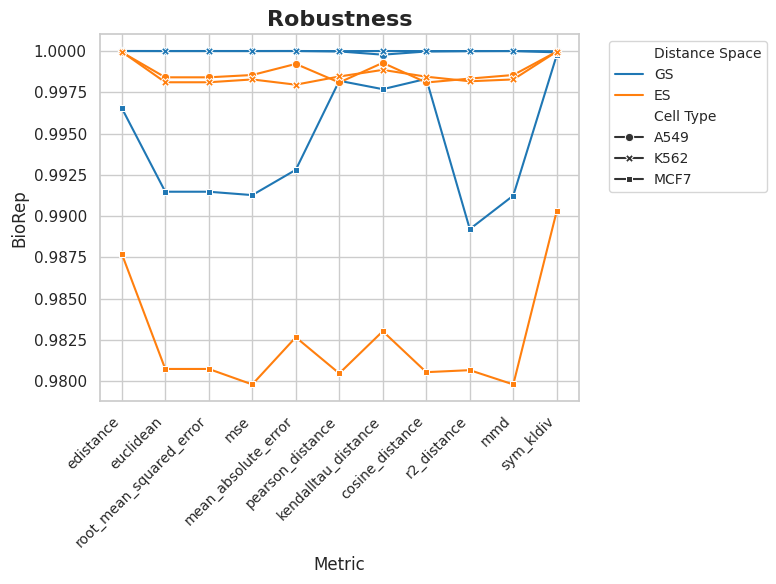

In [53]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df,
    x="Metric",
    y="Robustness",
    hue="Distance Space",
    style="Cell Type",
    markers=True,
    dashes=False,
    palette=distance_palette,
)
plt.title(f"Robustness", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Metric", fontsize=12)
plt.ylabel(score, fontsize=12)
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Place legend outside on the right
    ncol=1,
    fontsize=10,
    title_fontsize=12,
)
plt.tight_layout()

plt.savefig("./output/Robustness_comparison_plot.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

/tmp/ipykernel_3329439/1870078900.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


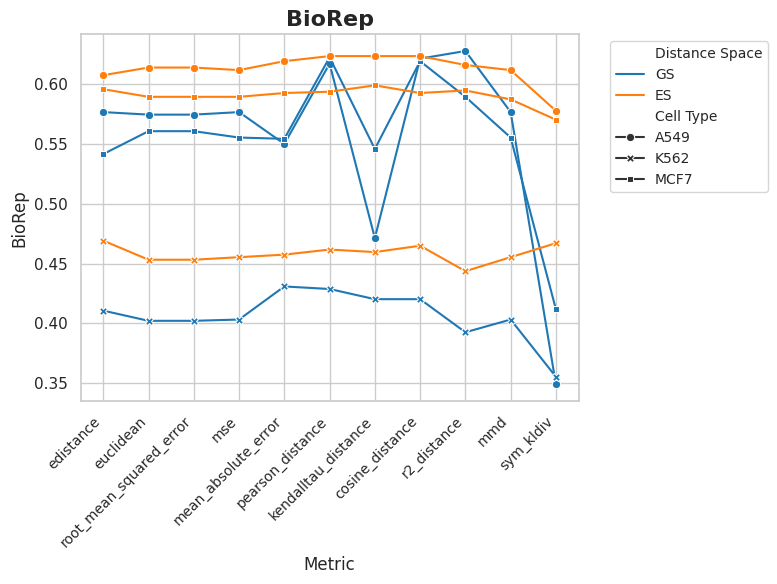

In [54]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df,
    x="Metric",
    y="BioRep",
    hue="Distance Space",
    style="Cell Type",
    markers=True,
    dashes=False,
    palette=distance_palette,
)
plt.title(f"BioRep", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Metric", fontsize=12)
plt.ylabel(score, fontsize=12)
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Place legend outside on the right
    ncol=1,
    fontsize=10,
    title_fontsize=12,
)
plt.tight_layout()

plt.savefig("./output/BioRep_comparison_plot.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()